In [52]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mlxtend.plotting import plot_decision_regions

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline  as imb_pipeline
from imblearn import FunctionSampler

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.metrics import classification_report, f1_score, auc, accuracy_score
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve

from prettytable import PrettyTable
from collections import Counter

%matplotlib inline
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

random_state = 42

In [4]:
df = pd.read_csv('../data/default-of-credit-card-clients.csv')
df = df.rename(columns={"PAY_0": "PAY_1"}, errors="raise")
df.drop(columns=['ID'],inplace=True)

## Feature Engineering

In [7]:
# round(abs(df.corr()['default payment next month']),2).sort_values(ascending=False)
# get the first seven rows

# low_corr_cols = pd.Series(round(abs(df.corr()['default payment next month']),2).sort_values(ascending=False)[8:].index)
# low_corr_cols.values

## Utils

In [8]:
def drop_correlated_data(df):    
    # remove the values that have a lower correlation in absolute value
    low_corr_cols = pd.Series(round(abs(df.corr()['default payment next month']),2).sort_values(ascending=False)[8:].index)
    df = df.drop(columns=low_corr_cols)
    
    y, X = df["default payment next month"], df.drop("default payment next month", axis=1)
    
    return X,y

def split_data(X,y, random_state=42):
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25,
                                                        stratify= y, random_state=random_state)

    return X_train, X_test, y_train, y_test

def report(y_true, y_pred, title = "", 
           params = None, show_cm = True, show_params = True):

    nl = '\n'
    sp = "*"*len(title)
    
#     print("__"*30 + nl)
    if title:
        title = "Classification report for " + title + " on yet-unseen data"
        sp = "*"*len(title)
        print(sp + nl + title + nl + sp +nl)
    
    acc = accuracy_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    print("Accuracy: {:.3f}".format(acc))
    print("f-score: {:.3f}".format(f_score))
    
    if params and show_params:
        new_params = {}
        for k in params:
            new_params[k.split("__")[-1]] = params[k]
            
        print("\nBest Parameters:")
#         pprint(new_params, indent = 4)
        print(grid_search.best_estimator_)
        
#     print(classification_report(y_true, y_pred))
    if show_cm:
        plt.figure(figsize = (6,5))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot = True, 
                    cmap = 'YlGnBu', 
                    annot_kws={"size": 18},
                    linecolor = 'w',
                    linewidth = 4
                   )
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted labels")
        plt.ylabel("True labels")
    
    return (acc, f_score)
    
scores_dict = {}
gs_trained_models =  {}

def outliers_iqr(X,y):
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    IQR = Q3 - Q1
    
    df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    y = df_out["default payment next month"]
    X = df_out.drop(columns=["default payment next month"])
    
    return X, y

def outliers_lof(X,y, n_neighbors=20):
    
    y = np.asarray(y)
    X = np.asarray(X)

    outliers = LocalOutlierFactor(n_neighbors = n_neighbors, n_jobs = -1).fit_predict(X)
    X = X[outliers == 1, :]
    y = y[outliers == 1]

    return X, y

### Pipeline

In [65]:
###### random_state = 42

param_grids = {
    "rf" : {
        "clf__n_estimators":[80,100,120],
        "clf__criterion":["gini", "entropy"],
        "clf__max_features":['sqrt','log2'],
        "clf__n_jobs": [-1],
    },
    "svc" : {
        "clf__kernel": ['linear', 'rbf', 'poly'],
        "clf__gamma" :['scale', 'auto'],
        "clf__C": [0.8, 1.0,1.2] 
    },
    "knn" : {
        "clf__n_neighbors": [10, 50, 75],
        "clf__weights": ["uniform", "distance"],
        "clf__algorithm": ["auto", "ball_tree", "kd_tree"],
        "clf__n_jobs": [-1],
    },
    "logisticregression" : {
        "clf__penalty": ['l1','l2'],
        "clf__tol": [1e-1, 1e-2, 1e-3, 1e-4],
        "clf__C": [0.6,0.8, 1.0,1.2, 1.4],
        "clf__solver" : ['saga'],
        "clf__max_iter" : [500]
    }
}

models = {
    "rf" : RandomForestClassifier(random_state=random_state),
    "knn" : KNeighborsClassifier(n_neighbors=9),
    "svc" : SVC(),
    "logistic": LogisticRegression(random_state=random_state)
} 

In [80]:
def training_pipeline(df, tests, model, param_grid, random_state=42):
    
    y, X = df["default payment next month"], df.drop("default payment next month", axis=1)
    X_train, X_test, y_train, y_test = split_data(X, y, 42)
    
    results = []
    counter = 1
    
    for curr_test in tests:
        
        outliers_option, scaling, pca, resampling = curr_test
    
        field_0 = ''

        pipe_steps = []
        
        if outliers_option == "LOF":
            field_0 += 'LOF +'
            pipe_steps.append(("outlier", FunctionSampler(func=outliers_lof)))
          
        if scaling:
            field_0 += 'SCALE + '
            pipe_steps.append(("scale",StandardScaler()))
        
        if pca:
            field_0 += 'PCA + '
            pipe_steps.append(("PCA",PCA(n_components=11, random_state=random_state)))
            
        if resampling:
            
            field_0 += f'{resampling}'
            
            if resampling == "RUS_50":
                pipe_steps.append((resampling, RandomUnderSampler(sampling_strategy=0.5, random_state=random_state))) # 50-50
            elif resampling == "RUS_60":
                pipe_steps.append((resampling, RandomUnderSampler(sampling_strategy=0.6, random_state=random_state))) # 62.5 - 37.5
            elif resampling == "SMOTE_50":
                pipe_steps.append((resampling,  SMOTE(sampling_strategy=0.5, random_state=random_state) )) # 50-50
            elif resampling == "SMOTE_60":
                pipe_steps.append((resampling,  SMOTE(sampling_strategy=0.65, random_state=random_state) )) # 60.61 - 30.39
            elif resampling == "SMOTEEN":
                pipe_steps.append((resampling, SMOTEENN(0.77,random_state=random_state))) # 50.21 - 49.29

        
        pipe_steps.append(('clf',model))
        
        pipeline = imb_pipeline(pipe_steps)    

        gridsearch = GridSearchCV(pipeline, param_grid, scoring='f1', n_jobs=-1)
        gridsearch.fit(X_train, y_train)

        best_estimator = gridsearch.best_estimator_

        y_pred = best_estimator.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        curr_result = (field_0, f1, gridsearch.best_params_)

        results.append(curr_result)
        
        print(f"{field_0} \t | Done {counter}/{len(tests)}")
        counter += 1
        
    return results, y_pred, y_test

def plot_summary(result,y_pred, y_test):
    
    fig = plt.figure(constrained_layout=False,figsize=(14,4))
    gs1 = fig.add_gridspec(nrows=1, ncols=6, left=0.1, right=0.90, wspace=0.5, hspace=0.5)
    ax1 = fig.add_subplot(gs1[0,0:3])
    ax2 = fig.add_subplot(gs1[0,3:5])
    
    
    plot_x = []
    plot_y = []
    
    for r in result:
        plot_x.append(r[1])
        plot_y.append(r[0])

    temp_df = pd.DataFrame({'x':plot_x, 'y' :plot_y}).sort_values(['x'], ascending=False)
    
    sns.barplot(x='x',y='y',data=temp_df, palette='viridis',ax=ax1)
    ax1.set_xlabel("F1-score", fontsize="14")
    ax1.set_ylabel("")
    ax1.set_yticklabels(temp_df.y,fontsize=13)
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, 
                cmap = 'viridis', 
                annot_kws={"size": 14},
                linecolor = 'w',
                linewidth = 4,ax=ax2,
                fmt='d'
               )
    
    ax2.set_xlabel("Predicted labels",fontsize="14")
    ax2.set_ylabel("True labels",fontsize="14")
    return plt

# Random Forest

In [ ]:
# outliers_option, scaling, pca, resampling = curr_test
# SET ALL COMBINATIONS

pca_options = [None, "PCA"]
scaling = [True]
outliers_options = [None, "LOF"]
resampling_options = [None, "RUS_50", "RUS_60", "SMOTE_50", "SMOTE_60", "SMOTEENN"]

tests = []

for o in outliers_options:
    for s in scaling:
        for p in pca_options:
            for r in resampling_options:
                tests.append([o,s,p,r])

# outliers_option, scaling, pca, resampling = curr_test
results_rf, y_pred_rf, y_test_rf = training_pipeline(df, tests, models["rf"], param_grids["rf"])

In [ ]:
sns.set_style('darkgrid')
plt_rf = plot_summary(results_rf,y_pred_rf, y_test_rf)
#plt_rf.savefig('../images/18-rf_results.svg')
plt_rf.show()

# KNN

In [ ]:
results_knn, best_estimator_knn = training_pipeline(df, tests, models["knn"], param_grids["knn"])

## Logistic Regression

In [81]:
pca_options = [None, "PCA"]
scaling = [True]
outliers_options = [None, "LOF"]
resampling_options = [None, "RUS_50", "RUS_60", "SMOTE_50", "SMOTE_60", "SMOTEENN"]

tests = []

for o in outliers_options:
    for s in scaling:
        for p in pca_options:
            for r in resampling_options:
                tests.append([o,s,p,r])

In [82]:
results_log, y_pred_log, y_test_log = training_pipeline(df, tests, models["logistic"], param_grids["logisticregression"])

SCALE +  	 | Done 1/24
SCALE + RUS_50 	 | Done 2/24
SCALE + RUS_60 	 | Done 3/24
SCALE + SMOTE_50 	 | Done 4/24
SCALE + SMOTE_60 	 | Done 5/24
SCALE + SMOTEENN 	 | Done 6/24
SCALE + PCA +  	 | Done 7/24
SCALE + PCA + RUS_50 	 | Done 8/24
SCALE + PCA + RUS_60 	 | Done 9/24
SCALE + PCA + SMOTE_50 	 | Done 10/24
SCALE + PCA + SMOTE_60 	 | Done 11/24
SCALE + PCA + SMOTEENN 	 | Done 12/24
LOF +SCALE +  	 | Done 13/24
LOF +SCALE + RUS_50 	 | Done 14/24


exception calling callback for <Future at 0x1fb8006d9a0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\Francesco\anaconda3\envs\venv-mml\lib\site-packages\joblib\externals\loky\process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "C:\Users\Francesco\anaconda3\envs\venv-mml\lib\multiprocessing\queues.py", line 122, in get
    return _ForkingPickler.loads(res)
MemoryError
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Francesco\anaconda3\envs\venv-mml\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\Francesco\anaconda3\envs\venv-mml\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\Francesco\anaconda3\envs\venv

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

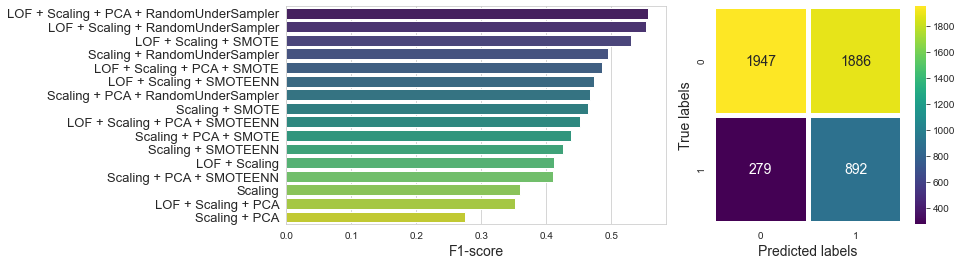

In [16]:
sns.set_style('whitegrid')
plt_lr = plot_summary(results_log,y_pred_log, y_test_log)
# plt_lr.savefig('../images/21-lr_results.svg')
plt_lr.show()

In [45]:
results_log

('LOF + Scaling + PCA + RandomUnderSampler',
  0.5561632309633993,
  {'logisticregression__C': 0.6,
   'logisticregression__max_iter': 500,
   'logisticregression__penalty': 'l1',
   'logisticregression__solver': 'saga',
   'logisticregression__tol': 0.01}),

[('Scaling',
  0.3590664272890485,
  {'logisticregression__C': 1.4,
   'logisticregression__max_iter': 500,
   'logisticregression__penalty': 'l1',
   'logisticregression__solver': 'saga',
   'logisticregression__tol': 0.0001}),
 ('Scaling + RandomUnderSampler',
  0.4955189361087019,
  {'logisticregression__C': 1.2,
   'logisticregression__max_iter': 500,
   'logisticregression__penalty': 'l1',
   'logisticregression__solver': 'saga',
   'logisticregression__tol': 0.001}),
 ('Scaling + SMOTE',
  0.46354733405875953,
  {'logisticregression__C': 1.4,
   'logisticregression__max_iter': 500,
   'logisticregression__penalty': 'l1',
   'logisticregression__solver': 'saga',
   'logisticregression__tol': 0.1}),
 ('Scaling + SMOTEENN',
  0.42649820727334814,
  {'logisticregression__C': 0.6,
   'logisticregression__max_iter': 500,
   'logisticregression__penalty': 'l2',
   'logisticregression__solver': 'saga',
   'logisticregression__tol': 0.001}),
 ('Scaling + PCA',
  0.2743022136669875,
  {'lo